# Inference Data Mount

In [17]:
!sudo mount -t nfs4 -o nfsvers=4.1,rsize=1048576,wsize=1048576,hard,timeo=600,retrans=2,noresvport 172.31.91.151:/ ./efs_inference_data

Password:


# For Docker Run / Sagemaker

In [3]:
!pip install rasterio geopandas shapely tensorflow-addons[tensorflow]

zsh:1: no matches found: tensorflow-addons[tensorflow]


# Start Local / Sagemaker Imports

In [1]:
import os
import rasterio as rio
import numpy as np
from rasterio.windows import Window
from glob import glob
from shapely.geometry import Polygon
from shapely.geometry import box
import geopandas as gpd
from rasterio.windows import get_data_window
import rasterio as rio
from inference_predict import *
import boto3
import matplotlib.pyplot as plt
import gdal

# Windowing

In [2]:
def get_windows(img_dim, patch_size=(240, 240), stride=(240, 240)):
    patch_size = np.array(patch_size)
    stride = np.array(stride)
    img_dim = np.array(img_dim)
    # to take into account edges, add additional blocks around right side edge and bottom edge of raster
    new_img_dim = [img_dim[0] + stride[0],img_dim[1] + stride[0]]
    
    max_dim = (new_img_dim//patch_size)*patch_size - patch_size

    ys = np.arange(0, img_dim[0], stride[0])
    xs = np.arange(0, img_dim[1], stride[1])

    tlc = np.array(np.meshgrid(ys, xs)).T.reshape(-1, 2)
    tlc = tlc[tlc[:, 0] <= max_dim[0]]
    tlc = tlc[tlc[:, 1] <= max_dim[1]]
    
    windows = []
    for y,x in tlc.astype(int):
        windows.append(Window(x, y, patch_size[1], patch_size[0]))

    return windows

In [3]:
def add_ndvi(data, dtype_1=rio.float32):
    
    nir = data[3].astype(dtype_1)
    red = data[0].astype(dtype_1)

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDVI
    ndvi = ((nir - red) / (nir + red)).astype(dtype_1)

    # Rescaling for use in 16bit output

    ndvi = (ndvi + 1) * (2**15 - 1)

    # Add NDVI band to end of array    
    rast = np.concatenate((data,[ndvi]),axis=0)
    
    rast = rast.astype(rio.uint16)
    
    return rast


# Download Model Files

In [4]:
# model_url = "s3://canopy-production-ml/inference/model_files/model-best.h5"
# weights_url = "s3://canopy-production-ml/inference/model_files/model_weights_best.h5"

# download_model(model_url,weights_url)

In [5]:
model = load_model("model.h5","model_weights.h5") 

In [6]:
label_list = ["Industrial_agriculture","ISL","Mining","Roads","Shifting_cultivation"]

In [10]:
def output_windows(granule_dir,patch_size=100,
                   stride=100,SAVE=False,SAVE_INDIVIDUAL=False,
                   bands=[2, 3, 4, 8, 11, 12], 
                  model=model,
                   predict_thresh=.5,
                  label_list=label_list, 
                  job_name="test_inference", 
                  output_filename="./inference_output/result.json"):
    
    granule_list = glob(f'{granule_dir}/*.tif')
    
    output_dict = {}
    
    granule_id_list = []
    
    window_id_list = []
    
    window_geom_list = []
    
    data_list = []
    
    label_master_list = []
    
    gdf_list = []
    
    timestamp = gen_timestamp()
    
    for j,granule_path in enumerate(granule_list):
        
        granule_id = granule_path.split("/")[-1].split("_")[0]
    
        with rio.open(granule_path) as src:

            windows = get_windows(src.shape, (patch_size, patch_size), (stride, stride))

            for i, window in enumerate(windows):
                
                print(f"predicting window {i + 1} of {len(windows)} of granulate {j + 1} of {len(granule_list)}",end='\r', flush=True)
                
                label_name_list = []
                
                window_id = i+1

                data = src.read(bands,window=window, masked=True)

                data = add_ndvi(data)
        
                shape = data.shape
            
                new_shape = (data.shape[0],patch_size,patch_size)
            
                if shape != new_shape:

                    filled_array = np.full(new_shape, 0)
                    filled_array[:shape[0],:shape[1],:shape[2]] = data
                    data = filled_array
                    window = Window(window.col_off,window.row_off,shape[2],shape[1])
                    
                    
                #image pre-processing / inference
                prediction = model.predict(read_image_tf_out(data))
                prediction = np.where(prediction > predict_thresh, 1, 0)
                prediction_i = np.where(prediction == 1)[1]
                for i in prediction_i:
                    label_name_list.append(label_list[i])
                
                label_master_list.append(label_name_list)
                
                #vectorizing raster bounds for visualization 
                window_bounds = rio.windows.bounds(window, src.transform, height=patch_size, width=patch_size)
                geom = box(*window_bounds)
                geom_coords = list(geom.exterior.coords)
#                 window_geom_list.append(geom)
                
                #create or append to dict....
                
                if granule_id in output_dict:

                    output_dict[granule_id].append({"window_id":window_id,"polygon_coords":geom_coords,"labels":label_name_list})

                else:

                    output_dict[granule_id] = [{"window_id":window_id,"polygon_coords":geom_coords,"labels":label_name_list}]
        
        save_to_s3(output_dict,output_filename,job_name,timestamp)
        


#             gdf = gpd.GeoDataFrame({"granule_id":granule_id_list,"window_id":window_id_list,"geometry":window_geom_list,"labels":label_master_list})
#             gdf["labels"] = gdf["labels"].astype(str)

#             gdf_list.append(gdf)
            
    return output_dict


    #             if SAVE:

    #                 if SAVE_INDIVIDUAL:
    #                     meta = raster.meta.copy()
    #                     # Get the window specific transform - IF we want to save windows independantly
    #             #         trans = raster.window_transform(window)
    #                     meta.update({
    #             #                 'transform': trans,
    #                             'dtype': src.dtype
    #                         })

    #                     with rasterio.open(f"{out_path}/some_chip_{j}.tif", 'w', **meta) as dest:
    #                         dest.write(data)
    #                 else:
    #                     meta = raster.meta.copy()

    #                     with rasterio.open(f"{out_path}/some_chip_{j}.tif", 'w+', **meta) as dest:
    #                         dest.write(data, window=window)

In [11]:
# granule_dir = "./efs_inference_data/"
granule_dir = "/Users/purgatorid/Downloads/granule_test/"

output_dict = output_windows(granule_dir)

In [28]:
output_dict

{'test.tif': [{'window_id': 1,
   'polygon_coords': [(-11169700.787427548, -4193553.7119406024),
    (-11169700.787427548, -4191764.5839900365),
    (-11171489.915378114, -4191764.5839900365),
    (-11171489.915378114, -4193553.7119406024),
    (-11169700.787427548, -4193553.7119406024)],
   'labels': []},
  {'window_id': 2,
   'polygon_coords': [(-11167911.659476982, -4193553.7119406024),
    (-11167911.659476982, -4191764.5839900365),
    (-11169700.787427548, -4191764.5839900365),
    (-11169700.787427548, -4193553.7119406024),
    (-11167911.659476982, -4193553.7119406024)],
   'labels': []},
  {'window_id': 3,
   'polygon_coords': [(-11166122.531526417, -4193553.7119406024),
    (-11166122.531526417, -4191764.5839900365),
    (-11167911.659476982, -4191764.5839900365),
    (-11167911.659476982, -4193553.7119406024),
    (-11166122.531526417, -4193553.7119406024)],
   'labels': []},
  {'window_id': 4,
   'polygon_coords': [(-11164333.40357585, -4193553.7119406024),
    (-11164333.4

In [12]:
data = output_dict

count = {}
label_match_results = []
granule_count = len(data.keys())
granule_list = data.keys()
count["granule_count"] = granule_count
for k1 in list(data.keys()):
    for i in range(len(data[k1])):
        if len(data[k1][i]['labels']) == 0:
            if "null_chips" not in count.keys():
                count["null_chips"] = 1
            else:
                count["null_chips"] += 1 
        for label in data[k1][i]['labels']:
            if label not in count.keys():
                count[label] = 1 
            else:
                    count[label] += 1 
        

In [13]:
count

{'granule_count': 1,
 'null_chips': 1495,
 'Shifting_cultivation': 409,
 'ISL': 30,
 'Industrial_agriculture': 2}

In [68]:
for i in range (len(output_dict['101'])):
    print(output_dict['101'][i]['labels'])

['Industrial_agriculture']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
['Industrial_agriculture']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['Industrial_agriculture']
['Industrial_agriculture']
['Industri

In [15]:
new_gdf.shape

(358780, 4)

<AxesSubplot:>

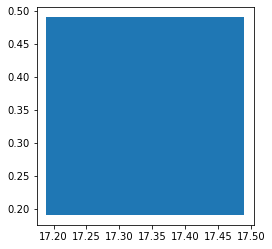

In [8]:
gdf.plot()

In [16]:
new_gdf.to_file("./inference_output/test.geojson", driver='GeoJSON')

In [20]:
gdf.to_file("./inference_output/test.geojson", driver='GeoJSON')

# Read Output Files

In [31]:
def process_output_files(json_path,download=True, filepath = "predict_test-2021-05-03-23-37-03.json", label_match="ISL"):

    s3 = boto3.resource('s3')

    #Download Model, Weights
    
    if download:
        
        bucket = json_path.split("/")[2]
        model_key = "/".join(json_path.split("/")[3:])
        filename = json_path.split("/")[-1]
        s3.Bucket(bucket).download_file(model_key, filename )
        filepath = filename
    
    with open(filepath) as jsonfile:
        data = json.load(jsonfile)
        

    count = {}
    label_match_results = []
    granule_count = len(data.keys())
    granule_list = data.keys()
    count["granule_count"] = granule_count
    for k1 in list(data.keys()):
        for i in range(len(data[k1])):
            if len(data[k1][i]['labels']) == 0:
                if "null_chips" not in count.keys():
                    count["null_chips"] = 1
                else:
                    count["null_chips"] += 1 
            for label in data[k1][i]['labels']:
                if label == label_match:
                    label_match_results.append([k1,data[k1][i]])
                if label not in count.keys():
                    count[label] = 1 
                else:
                    count[label] += 1 
    return count, label_match_results, granule_list, data

In [32]:
json_path = "s3://canopy-production-ml/inference/output/inference_output_test-2021-05-06-21-29-09.json"

count, match_results, granule_list, data = process_output_files(json_path)

In [45]:
polygon_list = []
for result in match_results:
    coords = result[1]["polygon_coords"]
    polygon = Polygon(coords)
    polygon_list.append(polygon)

In [48]:
gdf = gpd.GeoDataFrame({"geometry":polygon_list})

In [50]:
gdf = gdf.set_crs(epsg=3257)
        
gdf = gdf.to_crs(epsg=4326)

In [52]:
gdf.to_file("./inference_output/test_ISL.geojson", driver='GeoJSON')

In [30]:
data['test.tif'][0]["polygon_coords"]

[[-11169700.787427548, -4193553.7119406024],
 [-11169700.787427548, -4191764.5839900365],
 [-11171489.915378114, -4191764.5839900365],
 [-11171489.915378114, -4193553.7119406024],
 [-11169700.787427548, -4193553.7119406024]]

# Output Vectorized Predicted Granules

In [255]:
def s3_dir_match(s3_dir_url,granule_list):
    

    objs = []
    bucket = s3_dir_url.split("/")[2]
    key = "/".join(s3_dir_url.split("/")[3:5])

    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucket)

    window_geom_list = []
    granule_id_list = []
    for obj in my_bucket.objects.filter(Prefix=key):
        granule_id = obj.key.split("/")[-1].split("_")[0]
        if granule_id in granule_list:
            obj_url = "s3://" + bucket + "/" + obj.key
            with rio.open(obj_url) as src:
                bounds = src.bounds
                geom = box(*bounds)
                window_geom_list.append(geom)
                granule_id_list.append(granule_id)
    gdf = gpd.GeoDataFrame({"geometry":window_geom_list,"granule_id":granule_id_list})
                

    return gdf

In [256]:
gdf = s3_dir_match("s3://canopy-production-ml/full_congo_basin/02.17.21_CB_GEE_Pull/",granule_list)

In [257]:
gdf

,geometry,granule_id
0,"POLYGON ((17.48939 0.49039, 17.48939 0.79052, ...",1000
1,"POLYGON ((17.48939 0.19035, 17.48939 0.49048, ...",1001
2,"POLYGON ((17.48939 -0.10959, 17.48939 0.19044,...",1002
3,"POLYGON ((17.48939 -0.40963, 17.48939 -0.10950...",1003
4,"POLYGON ((17.48939 -0.70958, 17.48939 -0.40954...",1004
...,...,...
509,"POLYGON ((21.68937 -4.30958, 21.68937 -4.00954...",1473
510,"POLYGON ((21.68937 -4.60962, 21.68937 -4.30949...",1474
511,"POLYGON ((21.68937 -4.90965, 21.68937 -4.60953...",1475
512,"POLYGON ((21.68937 -5.20960, 21.68937 -4.90956...",1476


In [258]:
gdf.to_file("granules.json", driver="GeoJSON", index=True)

# Create and Export GDF of Original Labels Data

In [34]:
FILE_NAME = "/Users/purgatorid/Downloads/polygons_021521.csv"


df = pd.read_csv(
    FILE_NAME)
gdf = gpd.GeoDataFrame(
    df,
    crs={'init': 'epsg:4326'})

/Users/purgatorid/opt/anaconda3/envs/infer-conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/purgatorid/opt/anaconda3/envs/infer-conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  


In [35]:
polygons = []
for polygon in df["polygon"]:
    polygons.append(Polygon(json.loads(polygon)["coordinates"][0]))

In [36]:
gdf["geometry"] = polygons

In [39]:
gdf.loc[90]

image                                                             91
quality?                                                           N
center-lat                                                  -0.56656
center-long                                                 19.69196
polygon            {"type":"Polygon","coordinates":[[[19.85178,-0...
zoom                                                          @1000m
country                                                          DRC
concession                                                    024/11
added on                                                    6-Oct-20
revised on                                                       NaN
area (km2)                                                    278.44
tile date                                                  15-Jan-20
tile AWS path        s3://sentinel-s2-l2a/tiles/34/M/CE/2020/1/15/0/
URL                https://apps.sentinel-hub.com/eo-browser/?zoom...
Comments                          

In [252]:
gdf.to_file("output.json", driver="GeoJSON", index=True)

# Load and Reproject One Granulate Containing ISL 

In [14]:
def convert_raster(input_file, dest_dir, epsg_format='EPSG:3257', windows=False):
    """Converts the rasters in the src_dir into a different EPSG format,
    keeping the same folder structure and saving them in the dest_dir."""
    
    print(input_file)

    filename = "test.tif"
#     print(filename)

    # If the respective grouping folders are not available 

    output_filepath = dest_dir + filename
    print(output_filepath)


#         Finally, we convert
    converted = gdal.Warp(output_filepath, [input_file],format='GTiff',
                          dstSRS=epsg_format, resampleAlg='near')
    converted = None
        
    print('Finished')

In [16]:
granule = "/Users/purgatorid/Downloads/1241_full_congo_export_v12_all_bands_Feb_11_12_44_53_2021.tif"
dest_dir = "/Users/purgatorid/Downloads/"

convert_raster(granule,dest_dir)

/Users/purgatorid/Downloads/1241_full_congo_export_v12_all_bands_Feb_11_12_44_53_2021.tif
/Users/purgatorid/Downloads/test.tif
Finished


# Visualize Results (Incomplete Code)

In [142]:
def visualize_results(match_results,s3_url):
    for window in match_results:
        granule_id = window[0]
        

[['1005',
  {'window_id': 640,
   'polygon_coords': [[17.44079124118051, -0.8801693153803071],
    [17.44079124118051, -0.8711861625391119],
    [17.431808088339316, -0.8711861625391119],
    [17.431808088339316, -0.8801693153803071],
    [17.44079124118051, -0.8801693153803071]],
   'labels': ['Shifting_cultivation']}],
 ['1005',
  {'window_id': 642,
   'polygon_coords': [[17.458757546862902, -0.8801693153803071],
    [17.458757546862902, -0.8711861625391119],
    [17.449774394021706, -0.8711861625391119],
    [17.449774394021706, -0.8801693153803071],
    [17.458757546862902, -0.8801693153803071]],
   'labels': ['Shifting_cultivation']}],
 ['1005',
  {'window_id': 733,
   'polygon_coords': [[17.359942865609753, -0.9071187739038927],
    [17.359942865609753, -0.8981356210626975],
    [17.350959712768557, -0.8981356210626975],
    [17.350959712768557, -0.9071187739038927],
    [17.359942865609753, -0.9071187739038927]],
   'labels': ['Shifting_cultivation']}],
 ['1005',
  {'window_id':

In [201]:
t = {1,2,4}

# Running Without Windows Code - Direct Chip Predict 

In [113]:
def output_predictions(granule_dir,patch_size=100,
                   stride=100,SAVE=False,SAVE_INDIVIDUAL=False,
                   bands=[2, 3, 4, 8, 11, 12], 
                  model=model,
                   predict_thresh=.5,
                  label_list=label_list, 
                  job_name="test_inference", 
                  output_filename="./inference_output/result.json", 
                      apply_windows=False, 
                      read_process="read_img_tf_out", 
                      sample_frac=1):
    
    granule_list = glob(f'{granule_dir}/*.tif')
    
    end = len(granule_list) // sample_frac 
    
    granule_list = granule_list[0:end]
    
    print(f"running inference on {len(granule_list)} chips")
    
    output_dict = {}
    
    granule_id_list = []
    
    window_id_list = []
    
    window_geom_list = []
    
    data_list = []
    
    label_master_list = []
    
    gdf_list = []
    
    timestamp = gen_timestamp()
    
    missed_chips = []
    
    for j,granule_path in enumerate(granule_list):
        
        label_name_list = []
        
        granule_id = granule_path.split("/")[-1].split("_")[0]
        filepath = granule_path.split("/")[-1]
        
        if filepath:

            with rio.open(granule_path) as src:

                data = src.read(bands,masked=True)

                data = add_ndvi(data)

                shape = data.shape

                if apply_windows:

                    new_shape = (data.shape[0],patch_size,patch_size)

                    if shape != new_shape:

                        filled_array = np.full(new_shape, 0)
                        filled_array[:shape[0],:shape[1],:shape[2]] = data
                        data = filled_array
                        window = Window(window.col_off,window.row_off,shape[2],shape[1])

                #image pre-processing / inference


                if read_process == "read_img_tf_out":
                    read_func = read_image_tf_out
                else:
                    read_func = read_image

                prediction = model.predict(read_func(data))
#                 print("original_prediction:",prediction)
                prediction = np.where(prediction > predict_thresh, 1, 0)
#                 print("sigmoid prediction gate:",prediction)
                prediction_i = np.where(prediction == 1)[1]
                if 1 not in np.where(prediction == 1)[1]:
                    missed_chips.append(granule_path)
#                 print("index of matching labels:",prediction_i)
                for i in prediction_i:
                    label_name_list.append(label_list[i])

                label_master_list.append(label_name_list)

                #vectorizing raster bounds for visualization 
                data_bounds = src.bounds
                geom = box(*data_bounds)
                geom_coords = list(geom.exterior.coords)
    #                 window_geom_list.append(geom)

                #create or append to dict....

                if granule_id in output_dict:

                    output_dict[granule_id].append({"polygon_coords":geom_coords,"labels":label_name_list})

                else:

                    output_dict[granule_id] = [{"polygon_coords":geom_coords,"labels":label_name_list}]

        save_to_s3(output_dict,output_filename,job_name,timestamp)



    #             gdf = gpd.GeoDataFrame({"granule_id":granule_id_list,"window_id":window_id_list,"geometry":window_geom_list,"labels":label_master_list})
    #             gdf["labels"] = gdf["labels"].astype(str)

    #             gdf_list.append(gdf)

    return output_dict,missed_chips

In [114]:
# granule_dir = "./efs_inference_data/"
granule_dir = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Chips/misha_polygons_cloudfreemerge/yes/ISL/100/91/"

output_dict,missed_chips = output_predictions(granule_dir)

running inference on 75 chips


In [117]:
df = pd.DataFrame({"file_path":missed_chips})

In [118]:
df.to_csv("missed_chips.csv",index=False)

In [111]:
data = output_dict

count = {}
label_match_results = []
granule_count = len(data.keys())
granule_list = data.keys()
count["granule_count"] = granule_count
for k1 in list(data.keys()):
    for i in range(len(data[k1])):
        if len(data[k1][i]['labels']) == 0:
            if "null_chips" not in count.keys():
                count["null_chips"] = 1
            else:
                count["null_chips"] += 1 
        for label in data[k1][i]['labels']:
            if label not in count.keys():
                count[label] = 1 
            else:
                    count[label] += 1 
        

In [112]:
count

{'granule_count': 1,
 'ISL': 20,
 'Shifting_cultivation': 51,
 'null_chips': 2,
 'Industrial_agriculture': 1,
 'Roads': 1}

# Histogram for Numpy Array

In [46]:
data1.shape

(8, 100, 100)

In [84]:
def np_hist(arr,tensor=True):
    
    if tensor:
        arr = np.array(arr)
        arr = np.transpose(arr[0], (2, 1, 0))


    for i in range(arr.shape[0]):
        band_np = arr[i].flatten()
        plt.hist(band_np,label=str(i))


    plt.legend(prop={'size': 10})
    plt.show()
    

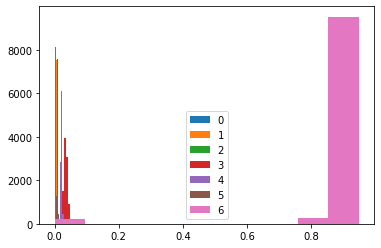

In [85]:
np_hist(data)

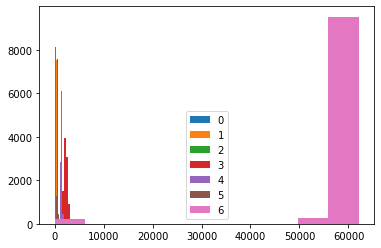

In [71]:
np_hist(data1,tensor=False)